In [2]:
import pandas as pd
import numpy as np

In [3]:
import pickle
import torch

/home/ajayago/anaconda3/envs/systematic_assessment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import yaml

In [5]:
import sys
sys.path.append("../Model/")

In [6]:
from src.vae_model import *
from src.gaussian_multinomial_diffusion import *
from src.modules import MLPDiffusion

In [7]:
device = torch.device("cuda:0")

In [8]:
sample_id = 2

In [9]:
config = yaml.safe_load(open(f"../Model/experiment_settings_yaml/model_config_2A_annotated_mutations_v7_fold{sample_id}.yaml"))
model_config = config["model_hyperparams"]

In [10]:
drug_fp = pd.read_csv(f"/data/ajayago/papers_data/systematic_assessment//raw/metadata/drug_morgan_fingerprints.csv", index_col=0)

In [12]:
# pass samples through the VAE and DDPM network, till just before VAE decoder
def vae_decoder_input(df, vae, diff_model):
    """
    Takes input df, pretrained vae and diffusion model as inputs, runs forward pass till VAE decoder
    """
    with torch.no_grad():
        batch = torch.tensor(df.values) # convert to torch tensor
        inp_vae = batch.to(device, dtype=torch.float32)
        inp, mu, logvar, _ = vae(inp_vae) # From VAE encoder + reparameterization
        
        noise = torch.randn_like(inp) # this is the label we use   
        b = inp.shape[0]
        t = (torch.ones((b,)) * 700).long().to(device) # fixing time steps to 700
        pt = torch.ones_like(t).float() / diff_model.num_timesteps
        inp_t = diff_model.gaussian_q_sample(inp, t, noise) # forward process with cell line model encoder
        
        model_out = diff_model._denoise_fn(inp_t, t) # predicted epsilon from patient decoder
    
        # predict inp from noise using patient model
        inp_pred = diff_model._predict_xstart_from_eps(inp_t, t, model_out)

    return inp_pred.detach().cpu().numpy()

In [13]:

def load_pretrained_models(sample_id):
    pretrained = torch.load(f"/data/ajayago/papers_data/DiffDRP_v7/run_files/saved_model_annotated_mutations//best_pretrained_validation_loss_val_corr_2A_ALL_fold{sample_id}.pth")
    is_real = True if model_config["input_data_type"] == "binary_mutations" else False
    # patients
    patient_vae = vae(input_dim=797, k_list=model_config["patient_vae_k_list"], actf_list=model_config["patient_vae_actf_list"], is_real=is_real).to(device)
    tcga_mlp_diffusion_model = MLPDiffusion(d_in=model_config["patient_vae_k_list"][-1]//2, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [model_config["patient_vae_k_list"][-1]//4], "dropout": model_config["dropout"]}).to(device)
    tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=model_config["patient_vae_k_list"][-1]//2, denoise_fn=tcga_mlp_diffusion_model, device=device)#.to(device)
    tcga_diff_model.load_state_dict(pretrained["patient_diff_model"])
    patient_vae.load_state_dict(pretrained["patient_vae_conditioned"])
    # cell lines
    cl_vae = vae(input_dim=model_config["feature_num"], k_list=model_config["cl_vae_k_list"], actf_list=model_config["cl_vae_actf_list"], is_real=is_real).to(device)
    cl_mlp_diffusion_model = MLPDiffusion(d_in=model_config["cl_vae_k_list"][-1]//2, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [model_config["cl_vae_k_list"][-1]//4], "dropout": model_config["dropout"]}).to(device)
    cl_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=model_config["cl_vae_k_list"][-1]//2, denoise_fn=cl_mlp_diffusion_model, device=device)#.to(device)
    cl_diff_model.load_state_dict(pretrained["cl_diff_model"])
    cl_vae.load_state_dict(pretrained["cl_vae_conditioned"])
    return cl_diff_model, cl_vae, tcga_diff_model, patient_vae

In [14]:
def load_datasets(sample_id):
    """
    Takes sample_id as input, loads source and target train, validation and test splits (predefined files from Processing folder).
    """
    data_dir = "/data/ajayago/papers_data/systematic_assessment/" + "input_types/"
    # navigate based on input type
    data_dir = data_dir + "transformer_inputs_transformed_797/"
    features2select = [f"transformer_embedded_{i}" for i in range(797)] # after transformer embedding

    data_dir = data_dir + "Experiment2/SettingA/"
    
    # load the fold based on sample_id - Note: cell lines have only 1 fold (fold 0)
    with open(f"{data_dir}/cell_lines_fold0_processed.pkl", "rb") as f:
        source_data = pickle.load(f)

    with open(f"{data_dir}/patients_fold{sample_id}_processed.pkl", "rb") as f:
        target_data = pickle.load(f)

    # load pretrained TCGA VAE and diffusion models
    # pass data points through patient DDPM and get the input to VAE decoder for DRP
    cl_diff_model, cl_vae, tcga_diff_model, patient_vae = load_pretrained_models(sample_id)
    
    # select data based on experiment settings 
    # Can be CISPLATIN, PACLITAXEL, FLUOROURACIL, SORAFENIB for 1A, CISPLATIN, TCGA-CESC; CISPLATIN, TCGA-HNSC; PACLITAXEL, TCGA-BRCA; FLUOROURACIL, TCGA-STAD for 1B
    # ALL for 2A, TCGA-BRCA, TCGA-CESC, TCGA-HNSC, TCGA-STAD for 2B
    train_source_data, val_source_data, test_source_data = source_data["train"].drop_duplicates(["sample_id"]), source_data["val"].drop_duplicates(["sample_id"]), source_data["test"].drop_duplicates(["sample_id"])
    train_target_data, val_target_data, test_target_data = target_data["train"].drop_duplicates(["sample_id"]), target_data["val"].drop_duplicates(["sample_id"]), target_data["test"].drop_duplicates(["sample_id"])
    
    # merge dataframes with drug Morgan fingprint dataframes
    train_source_data_merged = train_source_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    val_source_data_merged = val_source_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    test_source_data_merged = test_source_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)

    train_target_data_merged = train_target_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    val_target_data_merged = val_target_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    test_target_data_merged = test_target_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)

    assert train_source_data_merged.shape[0] == train_source_data.shape[0], "Train source data loss after merge!"
    assert val_source_data_merged.shape[0] == val_source_data.shape[0], "Val source data loss after merge!"
    assert test_source_data_merged.shape[0] == test_source_data.shape[0], "Test source data loss after merge!"
    assert train_target_data_merged.shape[0] == train_target_data.shape[0], "Train target data loss after merge!"
    assert val_target_data_merged.shape[0] == val_target_data.shape[0], "Val target data loss after merge!"
    assert test_target_data_merged.shape[0] == test_target_data.shape[0], "Test target data loss after merge!"

    # separate out into input, drug and labels
    train_source_inputs, val_source_inputs, test_source_inputs = train_source_data_merged[features2select], val_source_data_merged[features2select], test_source_data_merged[features2select]
    # pass cl samples through cl diff model and vae
    # train_source_inputs_vae = pd.DataFrame(vae_decoder_input(train_source_inputs, cl_vae, cl_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=train_source_data_merged.index)
    # val_source_inputs_vae = pd.DataFrame(vae_decoder_input(val_source_inputs, cl_vae, cl_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=val_source_data_merged.index)
    # test_source_inputs_vae = pd.DataFrame(vae_decoder_input(test_source_inputs, cl_vae, cl_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=test_source_data_merged.index)

    cl_vae.eval()
    train_source_inputs_vae = pd.DataFrame(cl_vae(torch.Tensor(train_source_inputs.values).to(device))[0].cpu().detach().numpy(), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=train_source_data_merged.index)
    val_source_inputs_vae = pd.DataFrame(cl_vae(torch.Tensor(val_source_inputs.values).to(device))[0].cpu().detach().numpy(), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=val_source_data_merged.index)
    test_source_inputs_vae = pd.DataFrame(cl_vae(torch.Tensor(test_source_inputs.values).to(device))[0].cpu().detach().numpy(), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=test_source_data_merged.index)
    train_source_drugs, val_source_drugs, test_source_drugs = train_source_data_merged[[str(i) for i in range(0, 2048)]].values, val_source_data_merged[[str(i) for i in range(0, 2048)]].values, test_source_data_merged[[str(i) for i in range(0, 2048)]].values
    train_source_labels, val_source_labels, test_source_labels = train_source_data_merged["auc"].values, val_source_data_merged["auc"].values, test_source_data_merged["auc"].values

    train_target_inputs, val_target_inputs, test_target_inputs = train_target_data_merged[features2select], val_target_data_merged[features2select], test_target_data_merged[features2select]
    # pass patient samples through tcga diff model and vae
    train_target_inputs_vae = pd.DataFrame(vae_decoder_input(train_target_inputs, patient_vae, tcga_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["patient_vae_k_list"][-1]//2)], index=train_target_data_merged.sample_id)
    val_target_inputs_vae = pd.DataFrame(vae_decoder_input(val_target_inputs, patient_vae, tcga_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["patient_vae_k_list"][-1]//2)], index=val_target_data_merged.sample_id)
    test_target_inputs_vae = pd.DataFrame(vae_decoder_input(test_target_inputs, patient_vae, tcga_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["patient_vae_k_list"][-1]//2)], index=test_target_data_merged.sample_id)

    train_target_drugs, val_target_drugs, test_target_drugs = train_target_data_merged[[str(i) for i in range(0, 2048)]].values, val_target_data_merged[[str(i) for i in range(0, 2048)]].values, test_target_data_merged[[str(i) for i in range(0, 2048)]].values
    train_target_labels, val_target_labels, test_target_labels = train_target_data_merged["recist"].values, val_target_data_merged["recist"].values, test_target_data_merged["recist"].values

    return train_source_inputs_vae, train_source_drugs, train_source_labels, val_source_inputs_vae, val_source_drugs, val_source_labels, test_source_inputs_vae, test_source_drugs, test_source_labels, train_target_inputs_vae, train_target_drugs, train_target_labels, val_target_inputs_vae, val_target_drugs, val_target_labels, test_target_inputs_vae, test_target_drugs, test_target_labels, train_source_data_merged, val_source_data_merged, test_source_data_merged, train_target_data_merged, val_target_data_merged, test_target_data_merged

    # pass # needs to return (train_source_data, train_source_labels, val_source_data, val_source_labels, test_source_data, test_source_labels), (train_target_data, train_target_labels, val_target_data, val_target_labels, test_target_data, test_target_labels)
    #  Dummy data
    # train_source_data, val_source_data, test_source_data = np.random.rand(32, 2048 + 4), np.random.rand(10, 2048 + 4), np.random.rand(5, 2048 + 4)
    # train_source_labels, val_source_labels, test_source_labels = np.random.randint(2, size=32), np.random.randint(2, size=10), np.random.randint(2, size=5)
    # train_target_data, val_target_data, test_target_data = np.random.rand(32, 2048 + 4), np.random.rand(10, 2048 + 4), np.random.rand(3, 2048 + 4)
    # train_target_labels, val_target_labels, test_target_labels = np.random.randint(2, size=32), np.random.randint(2, size=10), np.random.randint(2, size=3)
    # return train_source_data, train_source_labels, val_source_data, val_source_labels, test_source_data, test_source_labels, train_target_data, train_target_labels, val_target_data, val_target_labels, test_target_data, test_target_labels

def load_augmented_cl_dataset(sample_id):
    augmented_cl_df = pd.read_csv(f"/data/ajayago/papers_data/DiffDRP_v7/run_files/saved_model_annotated_mutations/augmented_cl_clconditioned_uda_v2_vaeinput_val_corr_2A_ALL_fold{sample_id}.csv", index_col=0)
    print(f"Loaded augmented CL data: {augmented_cl_df.shape}")
    augmented_cl_df_test = pd.read_csv(f"/data/ajayago/papers_data/DiffDRP_v7/run_files/saved_model_annotated_mutations/augmented_cl_test_clconditioned_uda_v2_vaeinput_val_corr_2A_ALL_fold{sample_id}.csv", index_col=0)
    print(f"Loaded augmented CL Test data: {augmented_cl_df_test.shape}")
    return augmented_cl_df, augmented_cl_df_test


In [15]:
# load datasets
train_source_inputs_vae, train_source_drugs, train_source_labels, val_source_inputs_vae, val_source_drugs, val_source_labels, test_source_inputs_vae, test_source_drugs, test_source_labels, train_target_inputs_vae, train_target_drugs, train_target_labels, val_target_inputs_vae, val_target_drugs, val_target_labels, test_target_inputs_vae, test_target_drugs, test_target_labels, train_source_data_merged, val_source_data_merged, test_source_data_merged, train_target_data_merged, val_target_data_merged, test_target_data_merged = load_datasets(sample_id)

# load augmented data for CL
cl_augmented_df, cl_augmented_df_test = load_augmented_cl_dataset(sample_id)


U: encoder 
Sequential(
  (enc-0): Linear(in_features=797, out_features=512, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=512, out_features=128, bias=True)
  (act-1): ReLU()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=512, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=512, out_features=797, bias=True)
  (act-1): Sigmoid()
)
U: encoder 
Sequential(
  (enc-0): Linear(in_features=797, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=

In [16]:
cl_augmented_df.shape

(1193, 64)

In [17]:
cl_augmented_df_test.shape

(1192, 64)

In [18]:
train_target_inputs_vae.shape

(452, 64)

In [19]:
test_target_inputs_vae.shape

(113, 64)

In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from scipy.stats import kstest, ks_2samp

In [23]:
test_source_inputs_vae.values.shape

(1192, 64)

In [24]:
train_source_inputs_vae 

,vae_feat0,vae_feat1,vae_feat2,vae_feat3,vae_feat4,vae_feat5,vae_feat6,vae_feat7,vae_feat8,vae_feat9,...,vae_feat54,vae_feat55,vae_feat56,vae_feat57,vae_feat58,vae_feat59,vae_feat60,vae_feat61,vae_feat62,vae_feat63
0,-0.924639,-0.425155,-2.643620,0.144451,-0.120782,-0.579607,-0.622841,-0.327620,-1.075307,-0.363752,...,0.113041,0.486911,-0.549094,-0.323256,-0.545375,0.905342,0.283548,0.120720,0.472985,-1.082896
1,-0.033144,-0.973273,0.955788,-1.180249,-1.006090,0.116078,0.685357,-0.411616,-0.674542,-0.541083,...,1.546192,0.012653,2.143658,-0.926635,1.693211,-0.254353,-0.902092,-0.213086,-0.331391,-0.203050
2,-1.145186,-0.571274,-0.650981,2.076808,-1.402827,1.280319,-2.122751,-0.901787,0.266240,-0.774131,...,-1.098978,0.276644,-0.684114,0.659168,-0.816362,-0.092638,0.191659,0.214109,-0.736807,-0.452299
3,-0.135186,-1.316955,-0.873753,-0.409157,0.370592,0.230296,-1.347618,-0.499856,-0.412861,-1.506298,...,0.075310,-1.968753,1.161537,-0.533786,1.324986,-1.708342,-1.108460,1.341232,3.315406,-0.847321
4,0.237753,1.088662,-0.249745,-0.498124,-1.151602,1.405432,0.911384,-0.059274,0.401984,-0.463301,...,-0.920938,0.579050,1.275775,-1.847139,0.968546,-0.725275,0.042498,1.908244,-0.818882,-0.676745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,0.208648,0.575015,0.973858,-0.442945,0.762136,-0.352909,0.713217,1.899957,-0.165514,-0.987414,...,0.649654,-1.282731,-0.887266,1.122660,0.587410,-0.716662,0.299707,1.118147,-1.132505,-2.113498
1189,0.096025,-0.843846,-0.332577,-0.157946,0.375576,0.305255,-1.569079,-1.080794,1.071621,0.255427,...,0.528651,0.059736,-0.725483,-0.744260,-0.607777,-0.515943,0.098410,-0.075492,0.373442,0.062277
1190,-0.378258,-0.330801,1.454936,-1.367472,-0.382196,-0.308939,-0.560337,-1.553530,2.570665,0.384105,...,0.443072,-1.589549,-1.771950,0.177262,1.644998,0.802924,-0.311402,1.158121,-1.075503,0.305672
1191,-0.211135,-0.479783,-0.211622,-0.211345,0.283063,-0.637053,1.388265,1.880178,-0.297933,0.384833,...,-0.403183,0.028133,-0.933157,0.046560,-0.490642,-1.904691,-0.343971,0.189873,-1.549557,0.326052


In [32]:
pca_patient = PCA(n_components=2, random_state=42)
pca_patient_df = pd.DataFrame(pca_patient.fit_transform(train_target_inputs_vae.values))
pca_patient_df.columns = ["comp1", "comp2"]

In [33]:
pca_cl_orig_df = pd.DataFrame(pca_patient.transform(train_source_inputs_vae.values))
# pca_cl_orig_df = pd.DataFrame(pca_patient.fit_transform(cl_augmented_df.values))
pca_cl_orig_df.columns = ["comp1", "comp2"]

In [34]:
pca_cl_df = pd.DataFrame(pca_patient.transform(cl_augmented_df.values))
pca_cl_df.columns = ["comp1", "comp2"]

Text(0.5, 1.0, 'After transformation')

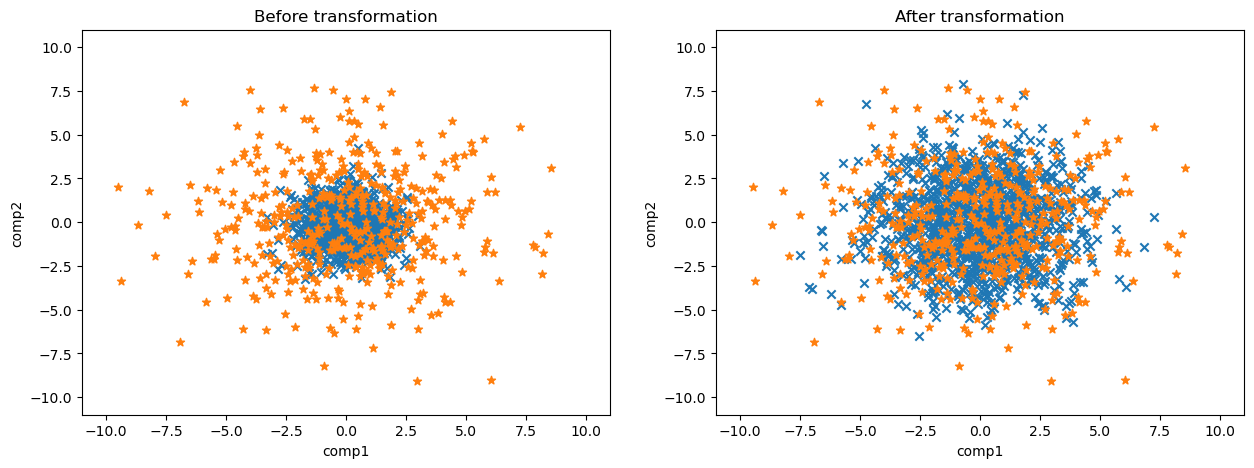

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_cl_orig_df["comp1"], pca_cl_orig_df["comp2"], marker="x")
ax[0].scatter(pca_patient_df["comp1"], pca_patient_df["comp2"], marker="*")
ax[0].set_xlabel("comp1")
ax[0].set_ylabel("comp2")
ax[0].set_xlim(-11, 11)
ax[0].set_ylim(-11, 11)
ax[0].set_title("Before transformation")

ax[1].scatter(pca_cl_df["comp1"], pca_cl_df["comp2"], marker="x")
ax[1].scatter(pca_patient_df["comp1"], pca_patient_df["comp2"], marker="*")
ax[1].set_xlabel("comp1")
ax[1].set_ylabel("comp2")
ax[1].set_xlim(-11, 11)
ax[1].set_ylim(-11, 11)
ax[1].set_title("After transformation")


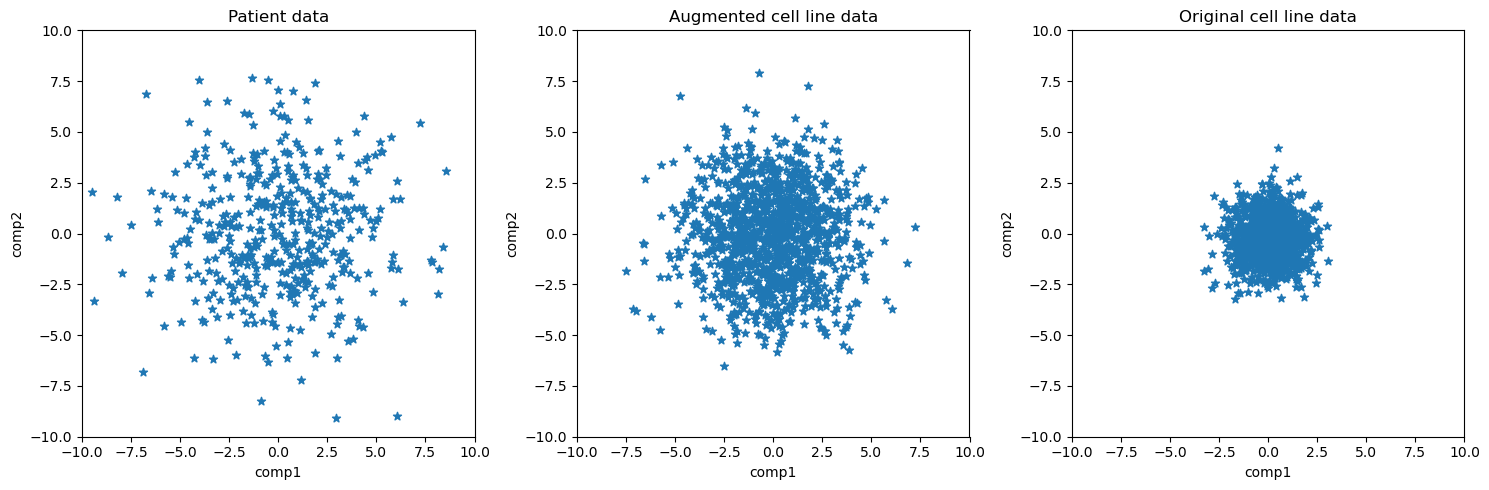

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(pca_patient_df["comp1"], pca_patient_df["comp2"], marker="*")
ax[0].set_xlabel("comp1")
ax[0].set_ylabel("comp2")
ax[0].set_xlim(-10, 10)
ax[0].set_ylim(-10, 10)
ax[0].set_title("Patient data")

ax[1].scatter(pca_cl_df["comp1"], pca_cl_df["comp2"], marker="*")
ax[1].set_xlabel("comp1")
ax[1].set_ylabel("comp2")
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)
ax[1].set_title("Augmented cell line data")

ax[2].scatter(pca_cl_orig_df["comp1"], pca_cl_orig_df["comp2"], marker="*")
ax[2].set_xlabel("comp1")
ax[2].set_ylabel("comp2")
ax[2].set_xlim(-10, 10)
ax[2].set_ylim(-10, 10)
ax[2].set_title("Original cell line data")
fig.tight_layout()

KS statistic between augmented CL and patient is less than that between CL orig and patient.

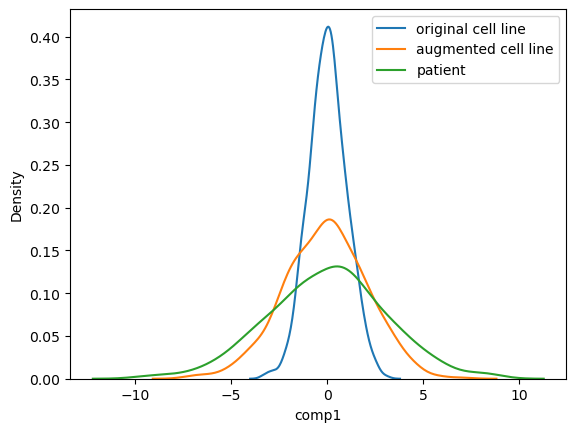

In [40]:
l1 = sns.kdeplot(data=pca_cl_orig_df, x="comp1")
l2 = sns.kdeplot(data=pca_cl_df, x="comp1")
l3 = sns.kdeplot(data=pca_patient_df, x="comp1")
plt.legend(["original cell line", "augmented cell line", "patient"])
plt.show()

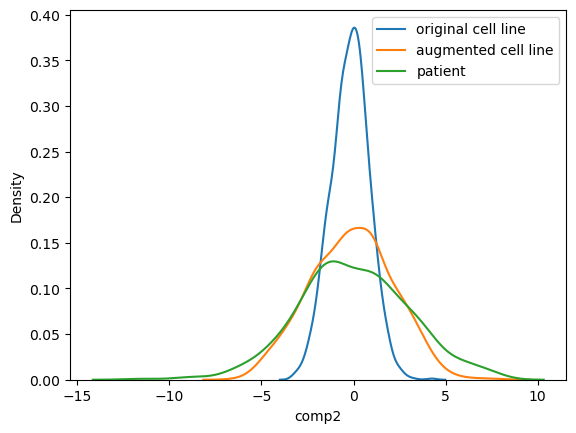

In [41]:
l1 = sns.kdeplot(data=pca_cl_orig_df, x="comp2")
l2 = sns.kdeplot(data=pca_cl_df, x="comp2")
l3 = sns.kdeplot(data=pca_patient_df, x="comp2")
plt.legend(["original cell line", "augmented cell line", "patient"])
plt.show()

In [42]:
#KS test between comp1 dist
kstest(pca_cl_df["comp1"].values, pca_patient_df["comp1"].values)

KstestResult(statistic=0.0960822348656247, pvalue=0.004325424278426591, statistic_location=2.707760711891986, statistic_sign=1)

In [43]:
#KS test between comp1 dist
kstest(pca_cl_orig_df["comp1"].values, pca_patient_df["comp1"].values)

KstestResult(statistic=0.25481050968407154, pvalue=3.288648169746237e-19, statistic_location=-1.376363, statistic_sign=-1)